# RNN in Numpy

Recurrent Neural Networks (RNN) are a class of Artificial Neural Networks that is extremely well equiped to process a sequence of inputs. Therefore, RNNs are usefull in time series. 

In this work, I created a RNN from scratch using Numpy. This RNN is based on Andrej Karpathy's char-rnn and will be the basis for a LSTM network. This network will be used to classify protein locations based on the amino acid sequence.

In [1]:
# First import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt
from module import Module
import embedding

In [2]:
# Random seed
np.random.seed(420)

# Set-up numpy generator for random numbers
random_number_generator = np.random.default_rng()

In [3]:
# Open the training data and save some important variables. If you want to train on your own text, just change the .txt file in the data variable.
#data = open('shakespeare.txt', 'r').read()
data = open('nescio.txt', 'r').read()
chars = list(set(data))
data_size = len(data)
vocab_size = len(chars)

In [4]:
print(f'Data set is length {data_size}')
print(f'Vocab set is length {vocab_size}')

Data set is length 201884
Vocab set is length 88


In [5]:
# Simple character embedding
char_to_idx = {char:i for i, char in enumerate(chars)}
idx_to_char = {i:char for i, char in enumerate(chars)}

In [6]:
# Embedding matrix to embed the tokenized sequence
def embed(embedding_dim, vocab_sz, rng):
    embedding = rng.random(size=(vocab_sz, embedding_dim))
    return embedding

In [7]:
# hyperparameters
hidden_size = 100
seq_length = 25
learning_rate = 1e-1
epochs = 10
embedding_dim = 10

In [24]:
class RNN(Module):
    r""" Simple recurrent neural network (RNN) class for an input sequence.
    
        This RNN initializes weight and gradients. And contains the forward
        and backward pass. The network is optimized using Adagrad.
        The train method is used to train the network.
        
        Parameters
        ----------
        seq_len : Number of layers connected to each others. 
        hidden_sz : The number of features in the hidden state h.
        vocab_sz : The number of possible inputs and outputs.
        
        
        Inputs (train)
        --------------
        data : Data used to train the network.
        optimizer : The optimizer that is used to train the network.
        lr : The learning rate used to train the network.
        epochs : The number of epochs to train the network.
        progress : If True, shows the progress of training the network.
        
        Inputs (predict)
        ----------------
        start : Start of a sentence that the network uses as initial sequence.
        n : Length of the prediction.
        
        
        Output (train)
        --------------
        smooth_loss : The loss of the current trained network.
        Wxh, Whh, Why : Updated weights of the network due to training.
        bh, by : Updated biases due to training.
        
        Output (predict)
        ----------------
        txt : A string that is predicted by the RNN.
    
    """
    
    def __init__(self, seq_len, hidden_sz, vocab_sz, embedding_dim):
        self.weight_params = ['Wxh', 'Whh', 'Why', 'Bh', 'By']
        self.hidden_params = ['hs']
        
        super().__init__(seq_len, hidden_sz, vocab_sz, self.weight_params, self.hidden_params, embedding_dim)
        
    def forward(self, xs, targets):
        """
        Forward pass of the RNN
        """
        
        y_preds = {}

        self.loss = 0

        for i in range(len(xs)):
            x = xs[i]
            
            # Vectorize the input
            x_vec = np.zeros((self.vocab_sz, 1)) # vectorize the input
            x_vec[x] = 1
            
            # Embed the vector
            embedded = np.dot(self.params['emb']['weight'].T, x_vec)

            # Calculate the new hidden, which is based on the input and the previous hidden layer
            self.hidden['hs'][i] = np.tanh(np.dot(self.params['Wxh']['weight'], embedded)
                                + np.dot(self.params['Whh']['weight'], self.hidden['hs'][i - 1]) 
                                + self.params['Bh']['bias'])
            # Predict y
            y_preds[i] = np.dot(self.params['Why']['weight'], self.hidden['hs'][i]) + \
            self.params['By']['bias'] 

            self.sm_ps[i] = np.exp(y_preds[i]) / np.sum(np.exp(y_preds[i])) # Softmax probabilty
            self.loss += -np.log(self.sm_ps[i][targets[i], 0]) #Negative loss likelyhood

        self.hidden['hs'][-1] = self.hidden['hs'][len(xs) - 1]
        
    def backward(self, xs, targets):
        """
        Backward pass of the RNN
        """
        # Initialize the gradients
        self.init_grads()
    
        # Initialize empty next hidden layer for the first backprop
        dhnext = np.zeros_like(self.hidden['hs'][0])
        
        for i in reversed(range(len(xs))):
            # X to vector
            x = xs[i]    
            x_vec = np.zeros((vocab_size, 1))
            x_vec[x] = 1
            
            # Embed the vector
            embedded = np.dot(self.params['emb']['weight'].T, x_vec)

            dy = np.copy(self.sm_ps[i])
            dy[targets[i]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here

            self.params['By']['grad'] += dy   
            self.params['Why']['grad'] += np.dot(dy, self.hidden['hs'][i].T)
            dh = np.dot(self.params['Why']['weight'].T, dy) + dhnext
            dhraw = (1 - self.hidden['hs'][i] * self.hidden['hs'][i]) * dh  
            self.params['Wxh']['grad'] += np.dot(dhraw, embedded.T)
            self.params['Whh']['grad'] += np.dot(dhraw, self.hidden['hs'][i-1].T)
            self.params['Bh']['grad'] += dhraw
            
            # Back to embedding
            dq = np.dot(self.params['Wxh']['weight'].T, dhraw)
            self.params['emb']['grad'] += (np.dot(dq, x_vec.T)).T
            dhnext = np.dot(self.params['Whh']['weight'].T, dhraw)

        # Clip to prevent exploding gradients
        for dparam in self.params.keys():
            np.clip(self.params[dparam]['grad'], -5, 5, out=self.params[dparam]['grad'])
    
    def predict(self, start, n):
        """
        Predict a sequence of text based on a starting string.
        """
        
        # Vectorize the input
        seed_idx = char_to_idx[start[-1]]
        x = np.zeros((self.vocab_sz, 1))
        x[seed_idx] = 1
        
        txt = [ch for ch in start]
        
        idxes = []
        
        h = self.hidden['hs'][-1]
        
        for i in range(n):
            
            # Embed the vector
            embedded = np.dot(self.params['emb']['weight'].T, x)
            
            # Calculate the hidden
            h = np.tanh(np.dot(self.params['Wxh']['weight'], embedded) \
                        + np.dot(self.params['Whh']['weight'], h) \
                        + self.params['Bh']['bias'])
            # Calculate y
            y = np.dot(self.params['Why']['weight'], h) \
                + self.params['By']['bias']

            sm_p = np.exp(y) / np.sum(np.exp(y)) # Softmax probabilty
            
            # Determine character based on weighted probability (is using the softmax probability)
            idx = np.random.choice(range(self.vocab_sz), p=sm_p.ravel())
            idxes.append(idx)
            
            # Save X for next iteration
            x = np.zeros((self.vocab_sz, 1))
            x[idx] = 1
            
        prediction = [idx_to_char[idx] for idx in idxes]
        
        txt += prediction
        
        return txt

In [25]:
model = RNN(seq_length, hidden_size, vocab_size, embedding_dim)

In [26]:
xs = [char_to_idx[ch] for ch in data[0:seq_length]]
targets = [char_to_idx[ch] for ch in data[1:seq_length+1]]
len(xs)

25

In [27]:
model.forward(xs, targets)

In [28]:
model.backward(xs, targets)

In [29]:
model.train(data, 'Adagrad', learning_rate, 1)

Epoch 1: 0 / 8075: 111.93342027364935
Epoch 1: 1000 / 8075: 92.55388918311452
Epoch 1: 2000 / 8075: 80.30092558612897
Epoch 1: 3000 / 8075: 74.3746325163231
Epoch 1: 4000 / 8075: 71.4864226021884
Epoch 1: 5000 / 8075: 70.41608928544005
Epoch 1: 6000 / 8075: 68.63085765391399
Epoch 1: 7000 / 8075: 67.5652476446767
Epoch 1: 8000 / 8075: 66.54791183618984


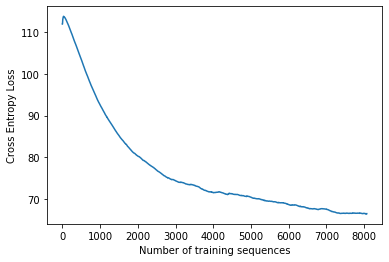

In [30]:
model.plot_losses()

In [31]:
prediction = model.predict('Gefeliciteerd', 50)
print(''.join(prediction))

Gefeliciteerdre  cteajd  iatele leo nkotleu ekeea tice eoweer
 


References:
* Fundamentals of Recurrent Neural Network (RNN) and Long Short-Term Memory (LSTM) Network 	Elsevier "Physica D: Nonlinear Phenomena" journal, Volume 404, March 2020: Special Issue on Machine Learning and Dynamical Systems (DOI: 	10.1016/j.physd.2019.132306)
* https://www.kdnuggets.com/2020/07/rnn-deep-learning-sequential-data.html
* https://gist.github.com/karpathy/d4dee566867f8291f086